In [1]:
import sys
sys.path.append("../")

In [2]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

from ppl import perplexity
from src.prompt import get_prompt
from src.utils import set_random_seeds, get_bnb_config

In [3]:
base_model_path = "../pretrain/Taiwan-LLM-7B-v2.0-chat"
peft_path = "../checkpoint/epoch=4_ppl=3.649335366725922"
test_data_path = "../data/public_test.json"

In [4]:
set_random_seeds()

# Load model
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
bnb_config = get_bnb_config()

# Zero-shot
zero_shot_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
zero_shot_model.eval()

# Few-shot
few_shot_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
few_shot_model.eval()

# LoRA
lora_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
lora_model = PeftModel.from_pretrained(lora_model, peft_path)
lora_model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
    

In [5]:
# Load dataset
with open(test_data_path, "r") as f:
    data = json.load(f)

In [6]:
zero_shot_ppl = perplexity(zero_shot_model, tokenizer, data, incontext=False)
few_shot_ppl  = perplexity(few_shot_model, tokenizer, data, incontext=True)
lora_shot_ppl = perplexity(lora_model, tokenizer, data, incontext=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:24<00:00, 10.22it/s]


In [7]:
print("Zero-shot Mean perplexity:", zero_shot_ppl["mean_perplexity"])
print("Zero-shot Std perplexity: ", zero_shot_ppl["std_perplexity"])

print("Few-shot Mean perplexity: ", few_shot_ppl["mean_perplexity"])
print("Few-shot Std perplexity:  ", few_shot_ppl["std_perplexity"])

print("LoRA Mean perplexity:     ", lora_shot_ppl["mean_perplexity"])
print("LoRA Std perplexity:      ", lora_shot_ppl["std_perplexity"])

Zero-shot Mean perplexity: 5.2045780034065245
Zero-shot Std perplexity:  4.1270745774025395
Few-shot Mean perplexity:  4.893454794406891
Few-shot Std perplexity:   3.8037628799112757
LoRA Mean perplexity:      3.647635447025299
LoRA Std perplexity:       2.7747906212759035


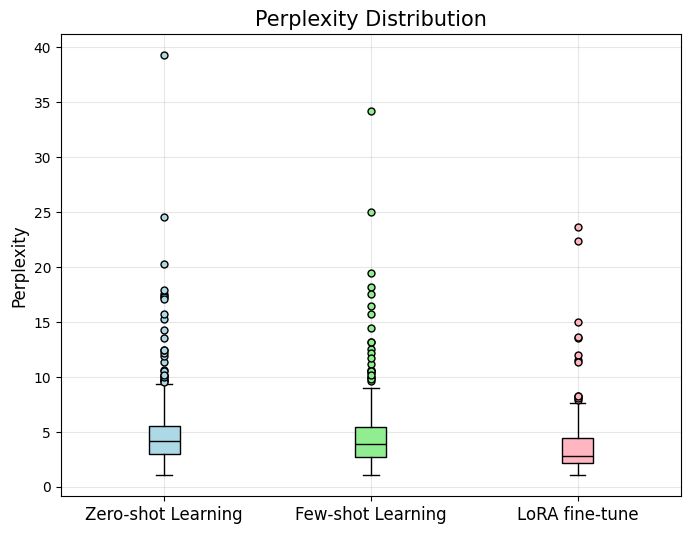

In [8]:
plt.figure(figsize=(8, 6))

plt.boxplot(zero_shot_ppl["perplexities"],
            positions=[1],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', markerfacecolor='lightblue', markersize=5)
)
plt.boxplot(few_shot_ppl["perplexities"],
            positions=[2],
            patch_artist=True,
            boxprops=dict(facecolor='lightgreen'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', markerfacecolor='lightgreen', markersize=5)
)
plt.boxplot(lora_shot_ppl["perplexities"],
            positions=[3],
            patch_artist=True,
            boxprops=dict(facecolor='lightpink'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', markerfacecolor='lightpink', markersize=5)
)


plt.title("Perplexity Distribution", fontsize=15)
plt.ylabel("Perplexity", fontsize=12)
plt.xticks([1, 2, 3], ["Zero-shot Learning", "Few-shot Learning", "LoRA fine-tune"], fontsize=12)
plt.grid(alpha=0.3)

plt.savefig("figures/perplexity_distribution.png")